# Trying CNN 

In [1]:
import torch
import pandas as pd
import numpy as np
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import time

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm as tqdm
from IPython.display import clear_output

from Network import *
from TorchMalaria import *

import matplotlib.pyplot as plt
from skimage.transform import resize

torch.set_num_threads(2)

In [2]:
data = DataMalaria("list_of_imagenames_with_label.csv", transform=torchvision.transforms.ToTensor(), TTS = True)

In [3]:
data.testmode()
len(data)

6890

In [4]:
data.trainmode()
batchsize = 200
trainloader = DataLoader(data, batch_size = batchsize, shuffle = True)
len(data)/batchsize

103.34

C:\Users\simcha\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


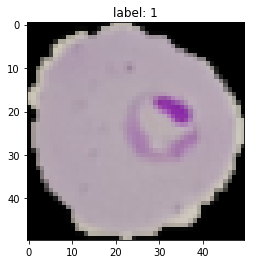

In [5]:
image, label = data[0]
data.imshowsingle(0)

In [6]:
trainIter = iter(trainloader)

batch = next(trainIter)
images, labels = batch
if len(images) < 10:
    # make grid takes tensor as arg
    # tensor : (batchsize, channels, height, width)
    grid = torchvision.utils.make_grid(images)
    fig = plt.figure(figsize=(10, 80))
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.axis('off')
    plt.title(labels.numpy())
    plt.show()

In [7]:
# initialize network and optimizer
network = Network()
network.double()
optimizer = optim.Adam(network.parameters(), lr = 0.01)

batch = next(iter(trainloader))
images, labels = batch

# forward pass + calculate loss
preds = network(images)
loss = F.cross_entropy(preds.double(), labels)

# backward propagation + updating weights
loss.backward()
optimizer.step()

################################

print("Loss 1: {}".format(loss.item()))
preds = network(images.double())
loss = F.cross_entropy(preds, labels)
print("Loss 2: {}".format(loss.item()))

Loss 1: 0.6952082935947689
Loss 2: 1.0338117564279674


In [8]:
data.trainmode()
network = Network()
network.double()
network.load_state_dict(torch.load("NetworkModel.pt"))
optimizer = optim.Adam(network.parameters(), lr = 0.005)

nEpochs = 3


for epoch in range(nEpochs):
    totalLoss = 0
    totalCorrect = 0
    counter = 0
    t = time.time()
    
    for batch in trainloader:
        images, labels = batch
        
        # forward pass + calculate loss
        preds = network(images)
        loss = F.cross_entropy(preds, labels)

        # PyTorch telt alle gradienten op. Daarom moet de gradient gereset worden.
        optimizer.zero_grad()

        # backward propagation + updating weights
        loss.backward()
        optimizer.step()

        totalLoss += loss.item()
        totalCorrect += GetNumCorrect(preds, labels)
        clear_output()
        counter += len(labels)
        print("{}/{}".format(counter, len(data)))
        print("epoch: {}\nTotalCorrect: {}\nTotalLoss: {}\n\nTime: {:3.1f}s\nAccuracy: {}\n\n".format(epoch, totalCorrect, totalLoss, time.time() - t, totalCorrect.item() / counter))


20668/20668
epoch: 2
TotalCorrect: 19625
TotalLoss: 15.93797498864425

Time: 318.5s
Accuracy: 0.9495355138378169




In [9]:
torch.save(network.state_dict(), "NetworkModel.pt")

In [10]:
network1 = Network()
network1.double()
network1.load_state_dict(torch.load("NetworkModel.pt"))

In [11]:
data.testmode()
testloader = DataLoader(data, batch_size = batchsize, shuffle = True)

In [12]:
batch = next(iter(testloader))
from sklearn.metrics import confusion_matrix
confmat = np.zeros((2, 2))

counter = 0
totalCorrect = 0 
for batch in testloader:
    images, labels = batch

    # forward pass + calculate loss
    preds = network1(images)
    confmat += confusion_matrix(labels, preds.argmax(dim = 1).numpy())
    clear_output()
    counter += len(labels)
    totalCorrect += GetNumCorrect(preds, labels)
    print("{}/{}".format(counter, len(data)))
    print("{:4.0f}|{:4.0f}\n{:4.0f}|{:4.0f}".format(confmat[0, 0], confmat[0, 1], confmat[1, 0], confmat[1, 1]))
    print("Accuracy: {}".format(totalCorrect.item()/counter))

6890/6890
3334| 100
 218|3238
Accuracy: 0.9538461538461539


In [17]:
totalCorrect.item()/counter

0.9246734397677794